# resolución solemne 1 minería de datos

Lo primero será importar las bibliotecas de Pandas, Google Cloud, request para visualizar una api publica y Matplotlib para graficar.

In [2]:
import requests
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt


En primer lugar, visualizaré los datos provenientes de la base de datos de BigQuery. Para ser más específico, los datos consultados son los siguientes: covid19_public_forecasts.

In [3]:
client = bigquery.Client()

#contruyo una referencia para el junto de datos de covid19
dataset_ref = client.dataset("covid19_public_forecasts", project="bigquery-public-data")

dataset = client.get_dataset(dataset_ref)

#Enumerar todas las tablas en el conjunto de datos "covid19_public_forecasts"
tables = list(client.list_tables(dataset))

# Imprimo los nombres de todas las tablas del conjunto de datos para tener una mejor visualizacion de lo que hay
for table in tables:  
    print(table.table_id)


county_14d
county_14d_historical
county_14d_historical_
county_28d
county_28d_historical
county_28d_historical_
japan_prefecture_28d
japan_prefecture_28d_historical
japan_prefecture_28d_historical_
state_14d
state_14d_historical
state_14d_historical_
state_28d
state_28d_historical
state_28d_historical_


Del conjunto de tablas visualizadas en el código anterior, se seleccionará la tabla county_28d_historical_ para realizar una visualización de su contenido. Esta visualización será utilizada como base para llevar a cabo un análisis más detallado.

In [4]:
table = dataset_ref.table("county_28d_historical_")

# API request - fetch the table
table = client.get_table(table)
client.list_rows(table, max_results=4).to_dataframe()

,county_fips_code,county_name,state_name,forecast_date,prediction_date,new_confirmed,cumulative_confirmed,cumulative_confirmed_q0025,cumulative_confirmed_q0975,new_confirmed_7day_rolling,...,recovered,recovered_q0025,recovered_q0975,new_confirmed_ground_truth,cumulative_confirmed_ground_truth,new_deaths_ground_truth,cumulative_deaths_ground_truth,hospitalized_patients_ground_truth,recovered_documented_ground_truth,county_population
0,01001,Autauga,Alabama,2020-12-03,2020-12-12,29.854402,3154.272486,2893.0,3842.892578,29.236568,...,2783.799805,2750.033447,3439.732666,NaN,NaN,NaN,NaN,NaN,NaN,55869
1,01001,Autauga,Alabama,2020-12-03,2020-05-25,NaN,NaN,NaN,NaN,6.857143,...,NaN,NaN,NaN,9.0,168.0,0.0,3.0,NaN,NaN,55869
2,01001,Autauga,Alabama,2020-12-03,2020-12-15,30.477970,3245.082371,2893.0,4079.764893,29.855966,...,2868.187012,2827.450195,3660.731445,NaN,NaN,NaN,NaN,NaN,NaN,55869
3,01001,Autauga,Alabama,2020-12-03,2020-12-10,29.442263,3094.769638,2893.0,3667.887451,28.824234,...,2727.918457,2699.731689,3274.896240,NaN,NaN,NaN,NaN,NaN,NaN,55869


de la tabla anterior podemos observar lo siguiente:
1. **county_fips_code**: Código FIPS del condado.
2. **county_name**: Nombre del condado.
3. **state_name**: Nombre del estado.
4. **forecast_date**: Fecha de pronóstico.
5. **prediction_date**: Fecha de predicción.
6. **new_confirmed**: Nuevos casos confirmados.
7. **cumulative_confirmed**: Total acumulado de casos confirmados.
8. **cumulative_confirmed_q0025**: Percentil 0.025 del total acumulado de casos confirmados.
9. **cumulative_confirmed_q0975**: Percentil 0.975 del total acumulado de casos confirmados.
10. **new_confirmed_7day_rolling**: Nuevo número de casos confirmados en un período de 7 días.
11. **new_deaths**: Nuevas muertes.
12. **cumulative_deaths**: Total acumulado de muertes.
13. **cumulative_deaths_q0025**: Percentil 0.025 del total acumulado de muertes.
14. **cumulative_deaths_q0975**: Percentil 0.975 del total acumulado de muertes.
15. **new_deaths_7day_rolling**: Nuevo número de muertes en un período de 7 días.
16. **hospitalized_patients**: Pacientes hospitalizados.
17. **hospitalized_patients_q0025**: Percentil 0.025 de pacientes hospitalizados.
18. **hospitalized_patients_q0975**: Percentil 0.975 de pacientes hospitalizados.
19. **recovered**: Recuperados.
20. **recovered_q0025**: Percentil 0.025 de recuperados.
21. **recovered_q0975**: Percentil 0.975 de recuperados.
22. **new_confirmed_ground_truth**: Nuevos casos confirmados (verdad del terreno).
23. **cumulative_confirmed_ground_truth**: Total acumulado de casos confirmados (verdad del terreno).
24. **new_deaths_ground_truth**: Nuevas muertes (verdad del terreno).
25. **cumulative_deaths_ground_truth**: Total acumulado de muertes (verdad del terreno).
26. **hospitalized_patients_ground_truth**: Pacientes hospitalizados (verdad del terreno).
27. **recovered_documented_ground_truth**: Recuperados (verdad del terreno).
28. **county_population**: Población del condado.



Utilizando los datos obtenidos, se  genera una consulta (query) para seleccionar las columnas más relevantes de nuestro conjunto de datos. Estas columnas seleccionadas se pasarán a la biblioteca Pandas para una manipulación más eficiente y efectiva. Este proceso nos permitirá concentrarnos en la información más importante para nuestro análisis posterior.

In [5]:
query = """
        SELECT state_name, forecast_date, prediction_date,new_confirmed, cumulative_confirmed, new_confirmed_7day_rolling, new_deaths, new_deaths_7day_rolling,
        FROM `bigquery-public-data.covid19_public_forecasts.county_28d_historical_`
        limit 500000
        """

# Create a QueryJobConfig object to estimate size of query without running it
dry_run_config = bigquery.QueryJobConfig(dry_run=True)

# API request - dry run query to estimate costs
dry_run_query_job = client.query(query, job_config=dry_run_config)

print("This query will process {} bytes.".format(dry_run_query_job.total_bytes_processed))

This query will process 975452294 bytes.



Como se puede observar en la parte anterior, la cantidad de memoria utilizada para visualizar esos datos es pequeña. Por esta razón, se puede trabajar con tranquilidad.
Sin embargo al ser una cantidad de datos muy grandes haremos un limite de 500 mil datos y realizaremos una muestra de los datos. 

In [6]:
query_job = client.query(query)
datos_generados = query_job.to_dataframe()
datos_generados

,state_name,forecast_date,prediction_date,new_confirmed,cumulative_confirmed,new_confirmed_7day_rolling,new_deaths,new_deaths_7day_rolling
0,Alabama,2020-12-02,2020-04-03,NaN,NaN,0.833333,NaN,0.166667
1,Alabama,2020-12-02,2020-09-19,NaN,NaN,2.571429,NaN,-0.142857
2,Alabama,2020-12-02,2020-09-03,NaN,NaN,6.428571,NaN,-0.142857
3,Alabama,2020-12-02,2020-01-22,NaN,NaN,1.903695,NaN,0.032891
4,Alabama,2020-12-02,2020-06-01,NaN,NaN,4.285714,NaN,-0.142857
...,...,...,...,...,...,...,...,...
499995,Puerto Rico,2020-12-05,2021-01-02,2.668121,415.688385,3.060516,0.025722,0.030725
499996,Puerto Rico,2020-12-05,2021-01-02,18.136719,11578.217773,10.379097,0.609469,0.293049
499997,Puerto Rico,2020-12-05,2021-01-02,4.906097,457.074951,5.333492,0.048981,0.059795
499998,Puerto Rico,2020-12-05,2021-01-02,14.744263,1733.265625,15.765154,0.130147,0.156268


In [7]:


# Suponiendo que ya tienes tu DataFrame llamado 'datos_generados'

# Utilizamos value_counts() para contar las ocurrencias de cada estado en la columna 'state_name'
conteo_estados = datos_generados['state_name'].value_counts()

# Imprimimos el conteo de ocurrencias de cada estado
print(conteo_estados)


state_name
Texas                   37771
Georgia                 29583
Indiana                 18839
Illinois                18535
Missouri                17523
Kentucky                16555
Virginia                15828
Kansas                  15788
North Carolina          14760
Iowa                    14413
Arkansas                14282
Tennessee               13618
California              13440
Nebraska                13440
Minnesota               13410
Ohio                    12632
Colorado                12581
Florida                 12254
Mississippi             12215
Michigan                11716
Oklahoma                11352
Wisconsin               11082
New York                10691
Alabama                 10613
Louisiana               10277
Pennsylvania             9805
Montana                  9102
South Dakota             8881
West Virginia            8262
North Dakota             8159
Idaho                    7795
Utah                     6466
Washington               6255

Como se puede observar anteriormente, tenemos una cantidad considerable de estados, lo que dificultaría su visualización en un gráfico, por ejemplo, del aumento de casos con respecto al tiempo. Por ello, para realizar un primer gráfico, utilizaremos solo los siguientes estados: Mississippi, Michigan, Oklahoma, Wisconsin y New York. Realizaremos una comparativa entre ellos.

In [8]:
# Estados seleccionados
estados_seleccionados = ['Mississippi', 'Michigan', 'Oklahoma', 'Wisconsin', 'New York']

# Filtrar los datos para incluir solo los estados seleccionados
datos_filtrados = datos_generados[datos_generados['state_name'].isin(estados_seleccionados)]

# Mostrar la información del DataFrame filtrado
print(datos_filtrados)

       state_name forecast_date prediction_date  new_confirmed  \
10134    Michigan    2020-12-02      2020-08-27            NaN   
10135    Michigan    2020-12-02      2020-07-16            NaN   
10136    Michigan    2020-12-02      2020-06-07            NaN   
10137    Michigan    2020-12-02      2020-07-22            NaN   
10138    Michigan    2020-12-02      2020-06-18            NaN   
...           ...           ...             ...            ...   
499949  Wisconsin    2020-12-05      2021-01-02     149.130299   
499950  Wisconsin    2020-12-05      2021-01-02       8.500665   
499951  Wisconsin    2020-12-05      2021-01-02       6.221129   
499952  Wisconsin    2020-12-05      2021-01-02      57.715958   
499953  Wisconsin    2020-12-05      2021-01-02      12.428233   

        cumulative_confirmed  new_confirmed_7day_rolling  new_deaths  \
10134                    NaN                  115.571429         NaN   
10135                    NaN                   97.571429       

como se realizaron demasiados filtros y esto puede tarar el proceso se procedera a crear un nuevo query que nos de los mismos datos recopilados anteriomente.

In [13]:

# Query optimizado para filtrar los datos por estado antes de traerlos
query = """
    SELECT state_name, forecast_date, prediction_date, new_confirmed, cumulative_confirmed, 
           new_confirmed_7day_rolling, new_deaths, new_deaths_7day_rolling
    FROM `bigquery-public-data.covid19_public_forecasts.county_28d_historical_`
    WHERE state_name IN ('Mississippi', 'Michigan', 'Oklahoma', 'Wisconsin', 'New York')
    limit 500000
"""

# Ejecutar la consulta
query_job = client.query(query)

# Convertir los resultados en un DataFrame
new_datos = query_job.to_dataframe()

# Mostrar la información del DataFrame filtrado
print(new_datos)


       state_name forecast_date prediction_date  new_confirmed  \
0        Michigan    2020-11-30      2020-07-21            NaN   
1        Michigan    2020-11-30      2020-12-06     881.578125   
2        Michigan    2020-11-30      2020-08-22            NaN   
3        Michigan    2020-11-30      2020-12-11     892.070312   
4        Michigan    2020-11-30      2020-12-16     882.035156   
...           ...           ...             ...            ...   
499995   New York    2020-11-23      2020-04-08            NaN   
499996   New York    2020-11-23      2020-09-30            NaN   
499997   New York    2020-11-23      2020-08-27            NaN   
499998   New York    2020-11-23      2020-09-02            NaN   
499999   New York    2020-11-23      2020-07-10            NaN   

        cumulative_confirmed  new_confirmed_7day_rolling  new_deaths  \
0                        NaN                   96.857143         NaN   
1               52065.175781                  909.167969   13.7

In [25]:
print(new_datos['forecast_date'].unique())

<DateArray>
[datetime.date(2020, 11, 30),  datetime.date(2020, 12, 2),
 datetime.date(2020, 11, 28),  datetime.date(2020, 12, 4),
 datetime.date(2020, 11, 25), datetime.date(2020, 11, 23)]
Length: 6, dtype: dbdate


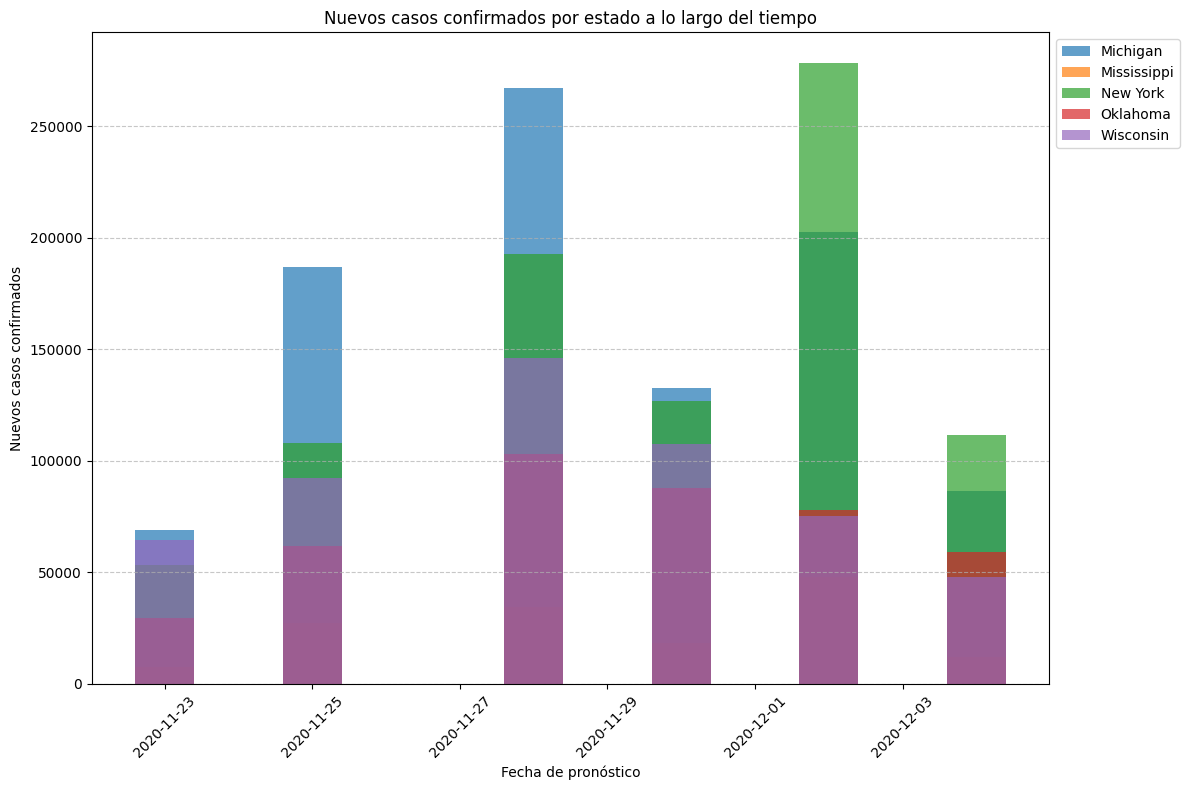

In [33]:


# Convertir la columna 'forecast_date' a tipo de dato datetime
new_datos['forecast_date'] = pd.to_datetime(new_datos['forecast_date'])

# Agrupar por estado y fecha de pronóstico, sumando los nuevos casos confirmados
grouped_data = new_datos.groupby(['state_name', 'forecast_date'])['new_confirmed'].sum().reset_index()

# Crear un gráfico de barras para cada estado
plt.figure(figsize=(12, 8))
for state in grouped_data['state_name'].unique():
    state_data = grouped_data[grouped_data['state_name'] == state]
    plt.bar(state_data['forecast_date'], state_data['new_confirmed'], label=state, alpha=0.7)

# Configurar el gráfico
plt.title('Nuevos casos confirmados por estado a lo largo del tiempo')
plt.xlabel('Fecha de pronóstico')
plt.ylabel('Nuevos casos confirmados')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Colocar la leyenda fuera del gráfico
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar rejilla solo en el eje y
plt.tight_layout()
plt.show()



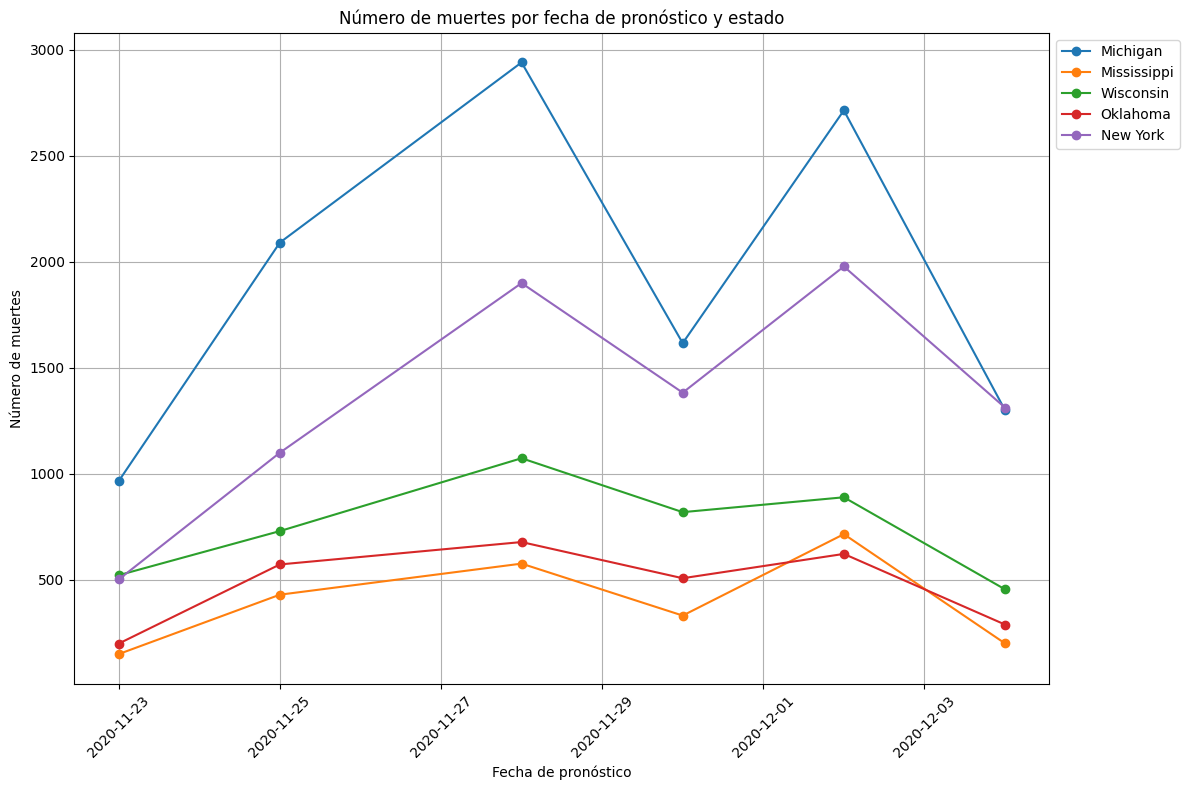

In [38]:

# Convertir la columna 'forecast_date' a tipo de dato datetime
new_datos['forecast_date'] = pd.to_datetime(new_datos['forecast_date'])

# Agrupar por estado y fecha de pronóstico, sumar el número de muertes
deaths_by_state_and_date = new_datos.groupby(['state_name', 'forecast_date'])['new_deaths'].sum()


plt.figure(figsize=(12, 8))
for state in new_datos['state_name'].unique():
    state_data = deaths_by_state_and_date[state]
    plt.plot(state_data.index, state_data.values, label=state, marker='o', linestyle='-')

# Configurar el gráfico
plt.title('Número de muertes por fecha de pronóstico y estado')
plt.xlabel('Fecha de pronóstico')
plt.ylabel('Número de muertes')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Colocar la leyenda fuera del gráfico
plt.grid(True)
plt.tight_layout()
plt.show()
